In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pymc as pm
from pymc.sampling_jax import get_jaxified_logp
import jax.numpy as jnp
import blackjax
import jax
import diffrax
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import arviz as az
import seaborn as sns
import preliz as pz
from diffrax_ODE_PyTensor import SolOp as SolOp_PyTensor
from diffrax_ODE_PyTensor import VJPSolOp as VJPSolOp_PyTensor
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

sys.path.append("../models/")
from huang_ferrell_1996 import *
from shin_2014 import *

from sampling_utils import *

plt.style.use('~/.matplotlib/custom.mplstyle')
# custom plotting helper funcs
sys.path.insert(0, '/Users/natetest/.matplotlib/')
import plotting_helper_funcs as plt_func

jax.config.update("jax_enable_x64", True)

/Users/natetest/miniforge3/envs/pymc5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test the function to generate a dose reponse curve using the Shin 2014 model

In [2]:
S_2014 = shin_2014(transient=True)
y0_dict, y0 = S_2014.get_initial_conditions()
p_dict, plist = S_2014.get_nominal_params()

data = pd.read_csv("../../../results/MAPK/HF_96_synthetic_data.csv")
inputs = np.array(data['stimulus'].to_numpy())

y0_EGF_ins = construct_y0_EGF_inputs(inputs, np.array([y0]), 0)


[]

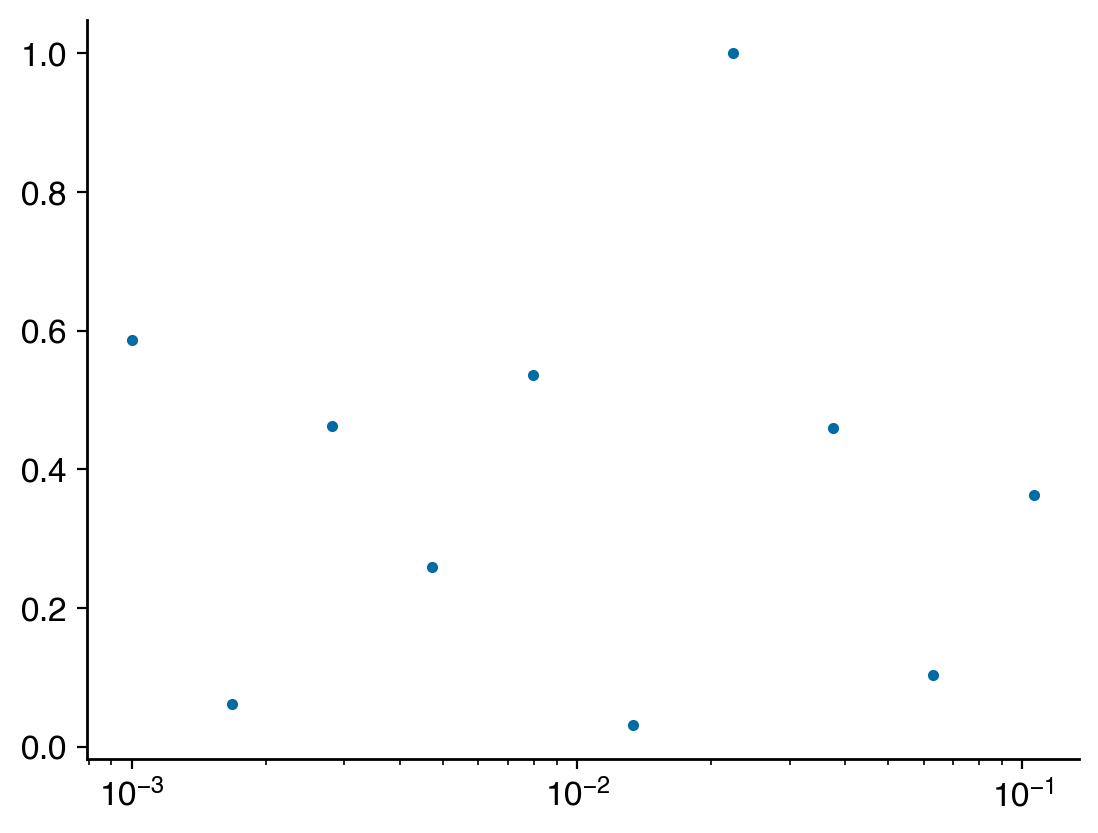

In [3]:
erk_act, _ = ERK_stim_response(plist, diffrax.ODETerm(S_2014), 540, y0_EGF_ins, [-1])
erk_act = np.array(erk_act)
fig, ax = plt.subplots()
ax.plot(inputs, erk_act, '.')
ax.semilogx()

### Test prior elicitation using preliz

(-4.6415484078104265, 97.47251656401896)

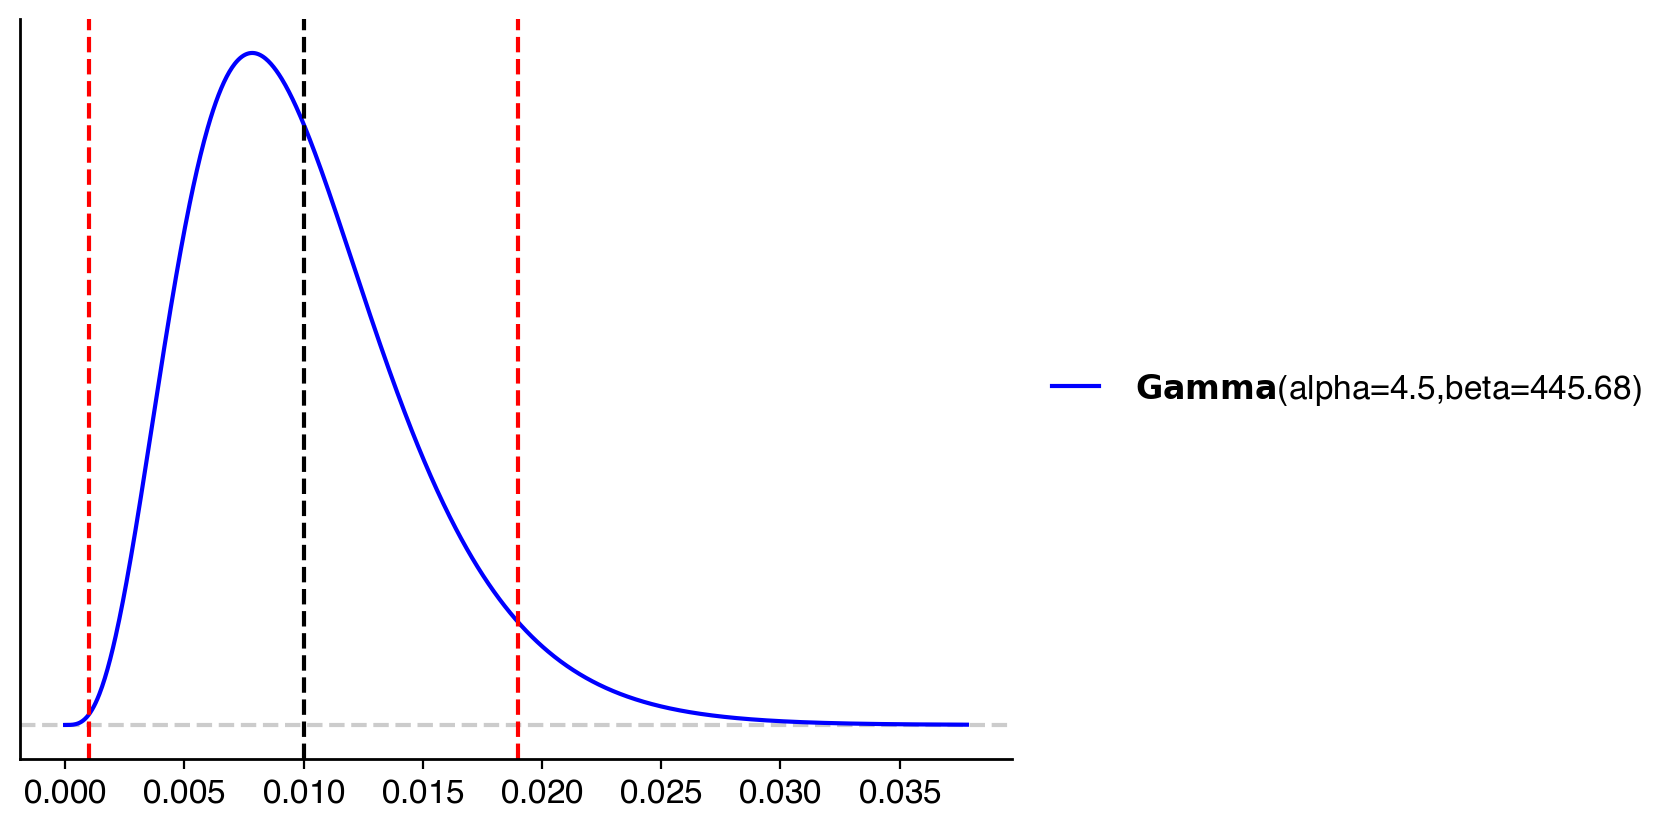

In [4]:
k = 0.01
upper, lower = 1.9*k, 0.1*k
results = pz.maxent(pz.Gamma(), lower, upper, 0.95, plot=False)[1]

ax = pz.Gamma(results.x[0], results.x[1]).plot_pdf(color='b')
ylim = ax.get_ylim()
ax.plot([k, k], ylim, 'k--')
ax.plot([lower, lower], ylim, 'r--')
ax.plot([upper, upper], ylim, 'r--')
ax.set_ylim(ylim)


### Test the automatic model generation code

In [5]:
param_names = ['a','b','c']
nominal_values = [0.1,1e-7,0.1]
free_param_idxs = [1,2]
priors = set_prior_params(param_names, nominal_values, free_param_idxs, upper_mult=1.9, lower_mult=0.1, prior_family={'Gamma':['alpha','beta']}, prob_mass_bounds=0.95)

print(priors)

with pm.Model() as model:
    for key, value in priors.items():
        exec(key + ' = ' + value)
    
    plist = list(map(eval, priors.keys()))
    print(plist)

print(model.free_RVs)

{'a': 'pm.ConstantData("a", 0.1)', 'b': 'pm.Gamma("b",alpha=4.498148159869361, beta=44567901.23456792, )', 'c': 'pm.Gamma("c",alpha=3.1989959668366437, beta=35.22781067467031, )'}
[TensorConstant(TensorType(float64, shape=()), data=array(0.1)), b, c]
[b, c]


### Test building a pymc model with the Shin 2014 model

In [4]:
S_2014 = shin_2014(transient=True)
y0_dict, y0 = S_2014.get_initial_conditions()
p_dict, plist = S_2014.get_nominal_params()

data = pd.read_csv("../../../results/MAPK/HF_96_synthetic_data.csv")
inputs = np.array(data['stimulus'].to_numpy())
erk_act_data = data['response'].to_numpy()

y0_EGF_ins = construct_y0_EGF_inputs(inputs, np.array([y0]), 0)

# free params
free_param_names = ['kc47', 'kc43', 'kd39', 'kc45', 'ERK_tot', 'ki39', 'kc41']
free_param_idxs = [list(p_dict.keys()).index(name) for name in free_param_names]

# set priors
prior_param_dict = set_prior_params(list(p_dict.keys()), plist, free_param_idxs, prior_family={'Gamma':['alpha', 'beta']}, upper_mult=1.9, lower_mult=0.1, prob_mass_bounds=0.95)

def solve_ss(model_dfrx_ode, y0, params, t1, erk_idx):
    """ simulates a model over the specified time interval and returns the 
    calculated steady-state values.
    Returns an array of shape (n_species, 1) """
    dt0=1e-3
    event_rtol=1e-8
    event_atol=1e-8
    solver = diffrax.Kvaerno5()
    event=diffrax.SteadyStateEvent(event_rtol, event_atol)
    stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-6)
    t0 = 0.0

    sol = diffrax.diffeqsolve(
        model_dfrx_ode, 
        solver, 
        t0, t1, dt0, 
        tuple(y0), 
        stepsize_controller=stepsize_controller,
        discrete_terminating_event=event,
        args=params,
        max_steps=6000,
        throw=False,)
    
    return jnp.array(sol.ys)

model_dfrx_ode = diffrax.ODETerm(S_2014)


def sol_op_jax(*params):
    pred, _ = ERK_stim_response(params, diffrax.ODETerm(S_2014), 540, y0_EGF_ins, [-1])
    return jnp.vstack((pred))

# get the jitted versions
sol_op_jax_jitted = jax.jit(sol_op_jax)

class StimRespOp(Op):
    def make_node(self, *inputs):
        # Convert our inputs to symbolic variables
        inputs = [pt.as_tensor_variable(inp) for inp in inputs]
        # Assume the output to always be a float64 matrix
        outputs = [pt.matrix()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        result = sol_op_jax_jitted(*inputs)
        outputs[0][0] = np.asarray(result, dtype="float64")
    
    def grad(self, inputs, output_grads):
        raise NotImplementedError("PyTensor gradient of StimRespOp not implemented")


# construct Ops and register with jax_funcify
sol_op = StimRespOp()

@jax_funcify.register(StimRespOp)
def sol_op_jax_funcify(op, **kwargs):
    return sol_op_jax

In [5]:
test_dat = np.vstack((erk_act))
print(test_dat.shape)

erk_act_data = np.vstack((data['response'].to_numpy()))
print(erk_act_data.shape)

(10, 1)
(10, 1)


In [6]:
model = pm.Model()
with model:
    # loop over free params and construct the priors
    priors = []
    for key, value in prior_param_dict.items():
        # create PyMC variables for each parameters in the model
        prior = eval(value)
        priors.append(prior)

    # predict dose response
    prediction = sol_op(*priors)

    tmp1 = pm.Deterministic('tmp1', prediction)

    # assume a normal model for the data
    # sigma specified by the data_sigma param to this function
    llike = pm.Normal("llike", mu=prediction, sigma=0.1, observed=erk_act_data)

In [44]:
a = pm.model_to_graphviz(model)
type(a)

graphviz.graphs.Digraph

### Now try with the build_pymc_model function that I wrote

In [8]:
model1 = build_pymc_model(prior_param_dict, erk_act_data, y0_EGF_ins, 
                    [-1], 540, diffrax.ODETerm(S_2014))

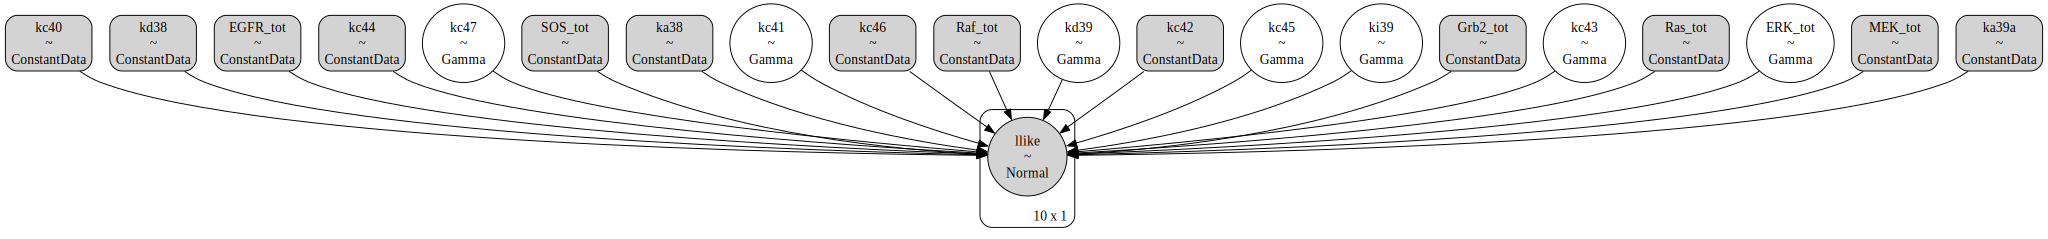

In [13]:
pm.model_to_graphviz(model1)

### How does prior predictive sampling look?

In [14]:
idata_ppc = pm.sample_prior_predictive(model=model1, samples=500)

Sampling: [ERK_tot, kc41, kc43, kc45, kc47, kd39, ki39, llike]


<ErrorbarContainer object of 3 artists>

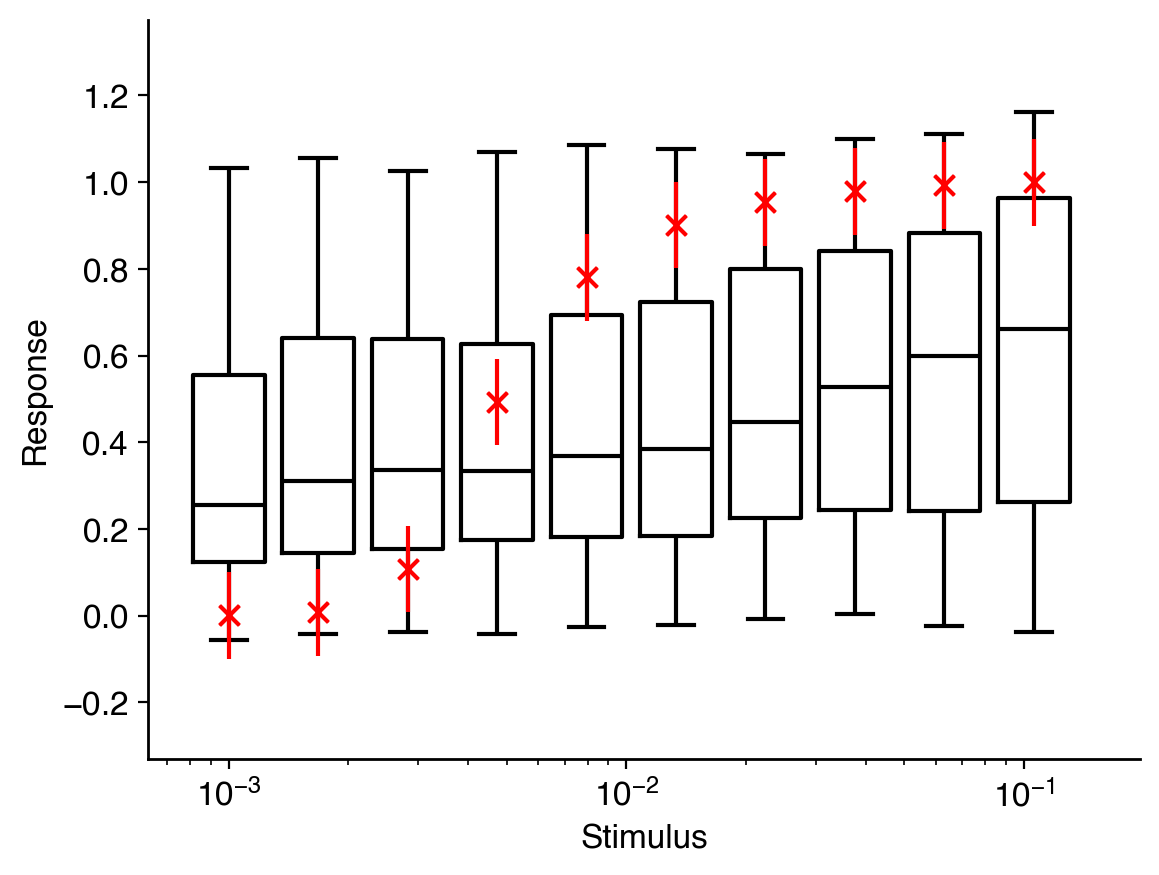

In [16]:
# prior_stim_resp = np.squeeze(idata_ppc.prior['tmp1'].values)
prior_llike = np.squeeze(idata_ppc.prior_predictive['llike'].values)

dat = {}
for i,input in enumerate(inputs):
    dat[input] = prior_llike[:,i]

data_df = pd.DataFrame(dat)

fig, ax = plt.subplots()
sns.boxplot(data=data_df, color='k', ax=ax, whis=(2.5, 97.5), fill=False, 
            native_scale=True, log_scale=(10, 0), fliersize=0)
ax.set_xlabel('Stimulus')
ax.set_ylabel('Response')

errors = 0.1*np.squeeze(np.ones_like(erk_act_data))
ax.scatter(inputs, erk_act_data, color='r', marker='x', s=50, zorder=10)
ax.errorbar(inputs, np.squeeze(erk_act_data), yerr=errors, color='r', fmt='x', markersize=7, zorder=10)

Sampling: [ERK_tot, kc41, kc43, kc45, kc47, kd39, ki39, llike]


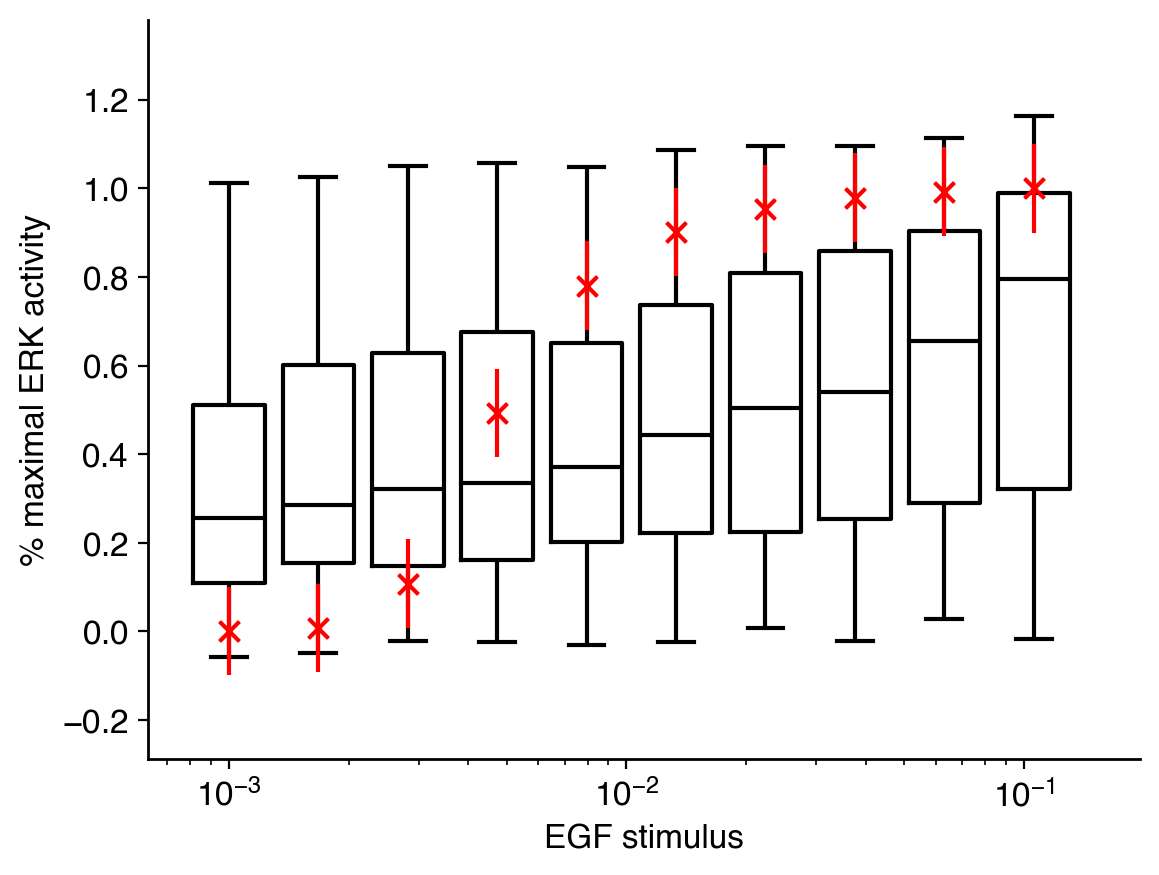

In [18]:
create_prior_predictive(model1, 'shin_2014', erk_act_data, inputs, './', 
                            nsamples=500, seed=np.random.default_rng(seed=123))

### Test the SMC sampling function

In [27]:
with model1:
        idata = pm.smc.sample_smc(draws=1000, random_seed=np.random.default_rng(seed=123), chains=None, progressbar=False)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


array([[<Axes: title={'center': 'ERK_tot'}>,
        <Axes: title={'center': 'ERK_tot'}>],
       [<Axes: title={'center': 'ki39'}>,
        <Axes: title={'center': 'ki39'}>],
       [<Axes: title={'center': 'kd39'}>,
        <Axes: title={'center': 'kd39'}>],
       [<Axes: title={'center': 'kc41'}>,
        <Axes: title={'center': 'kc41'}>],
       [<Axes: title={'center': 'kc43'}>,
        <Axes: title={'center': 'kc43'}>],
       [<Axes: title={'center': 'kc45'}>,
        <Axes: title={'center': 'kc45'}>],
       [<Axes: title={'center': 'kc47'}>,
        <Axes: title={'center': 'kc47'}>]], dtype=object)

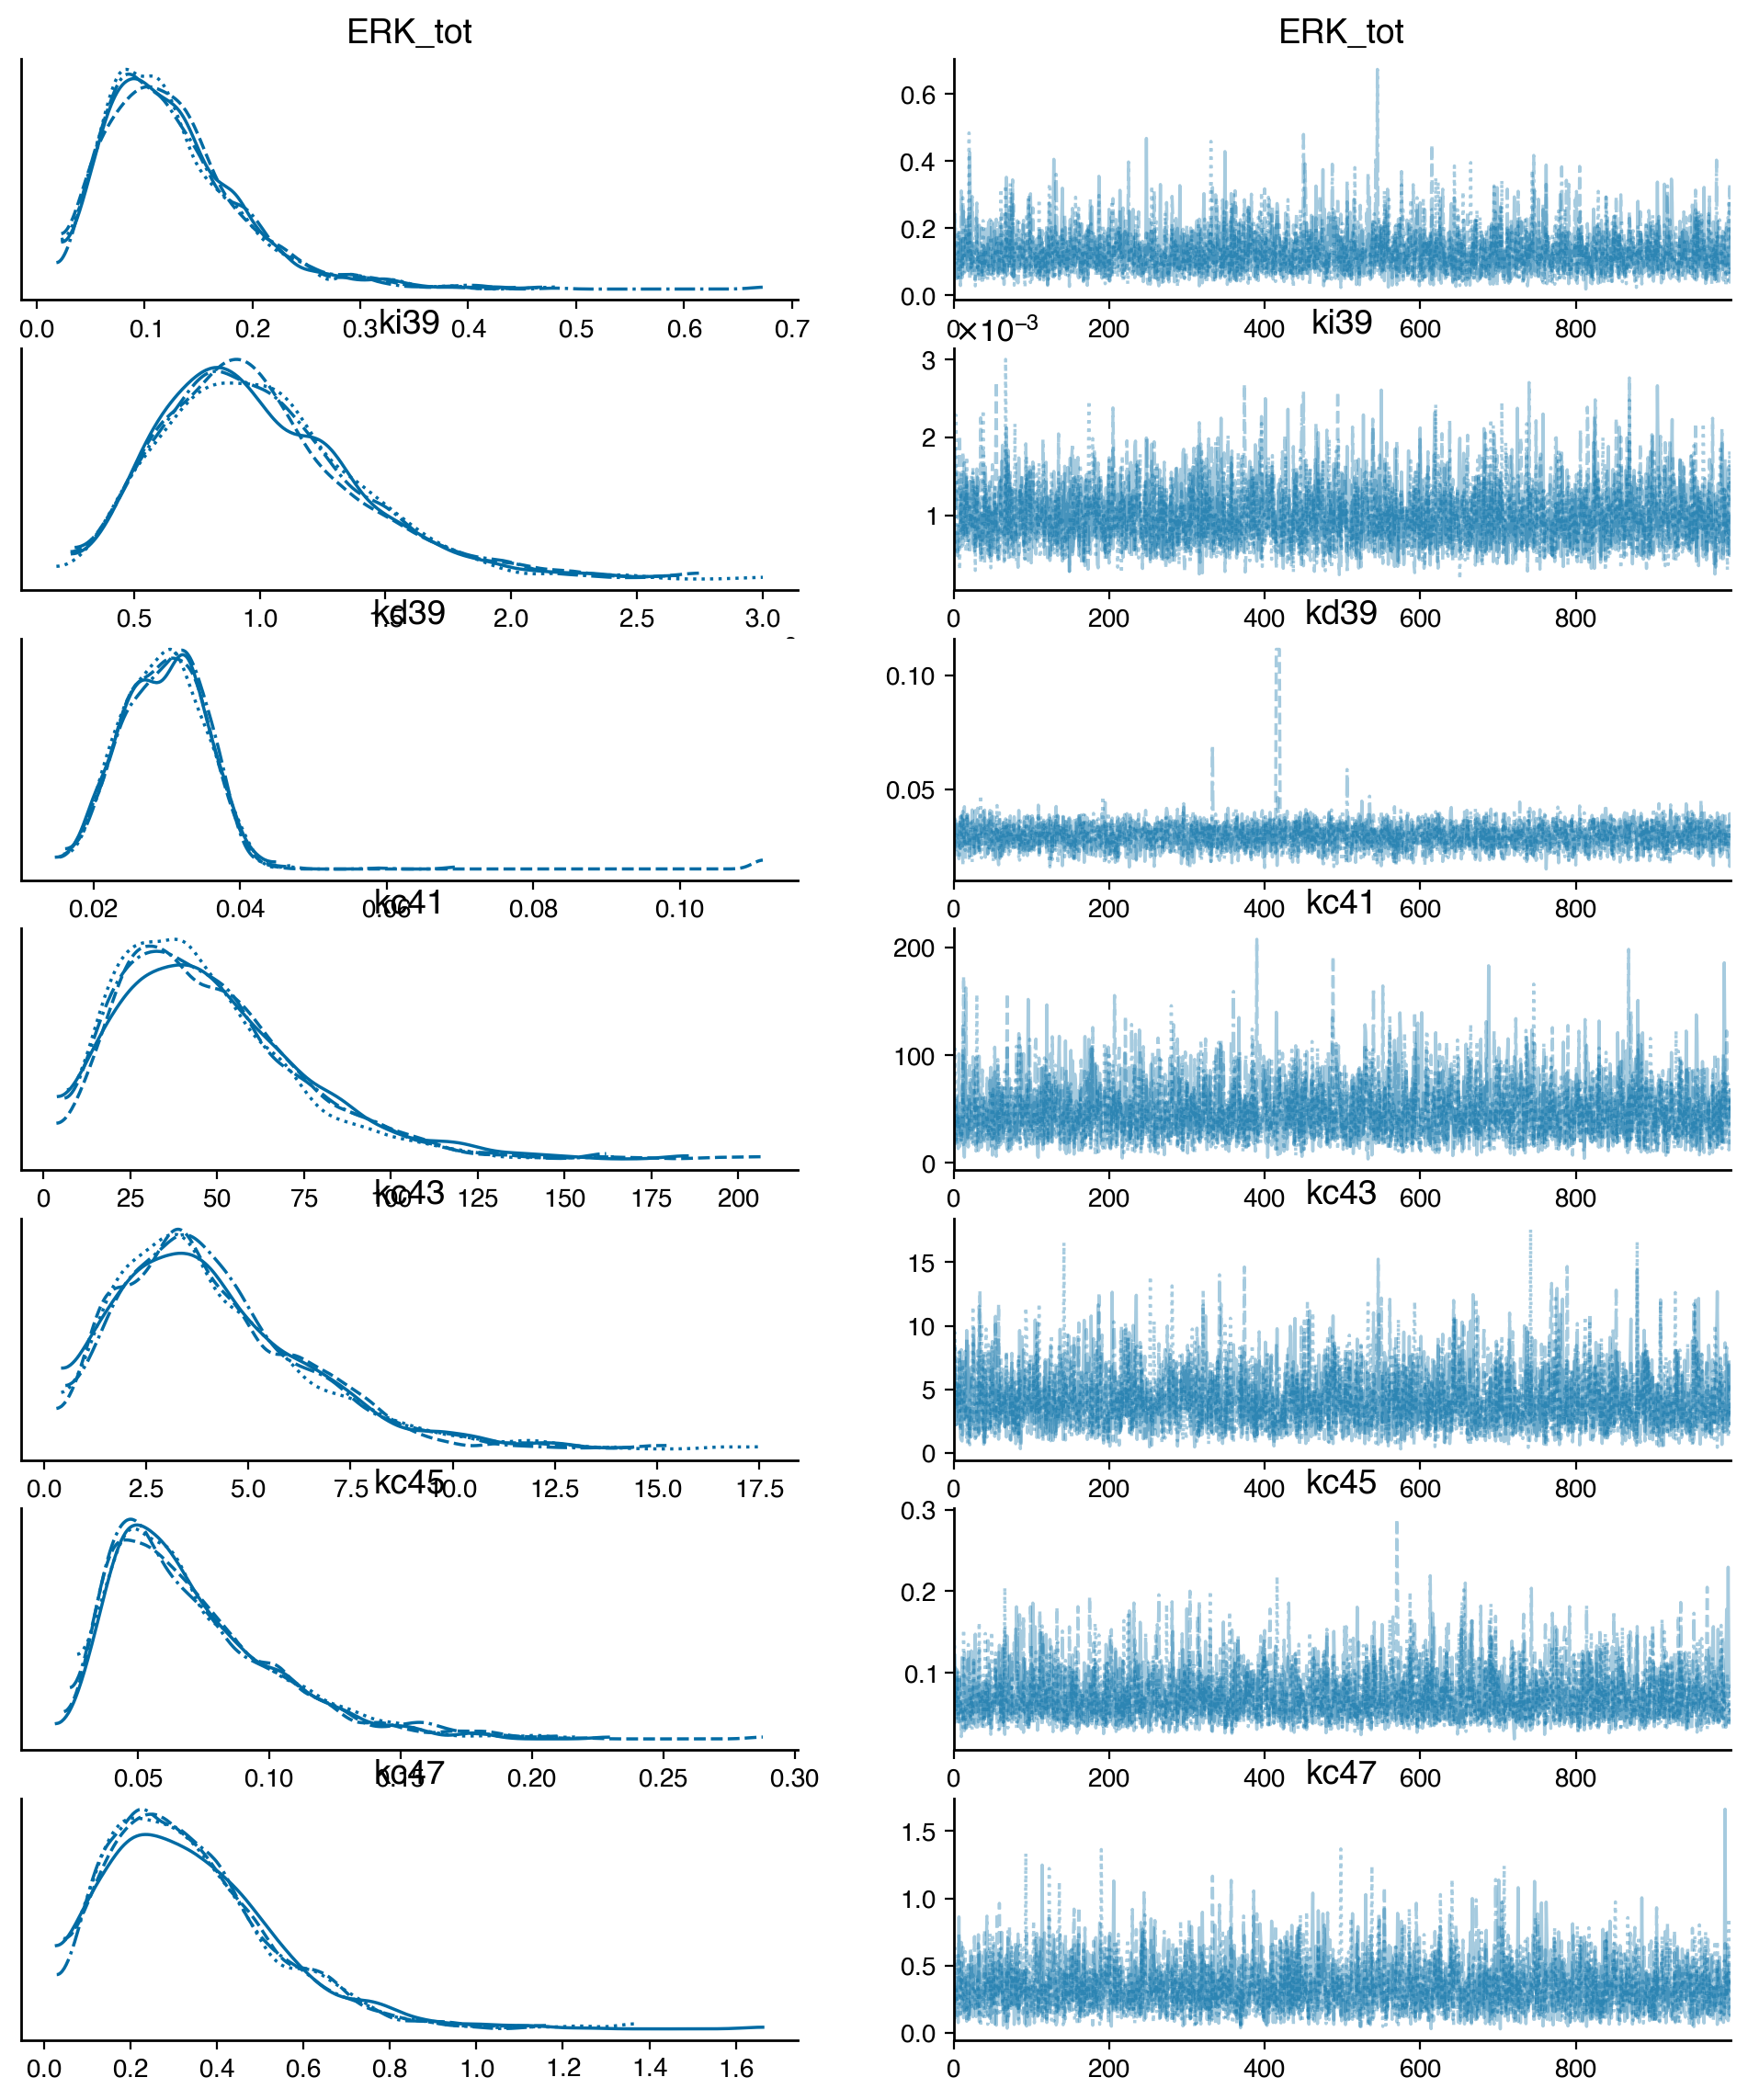

In [41]:
az.plot_trace(idata)

In [28]:
def create_posterior_predictive(model, posterior_idata, mapk_model_name, data, inputs, savedir, 
            seed=np.random.default_rng(seed=123)):
    """ Creates prior predictive samples plot of the stimulus response curve.
    """

    # sample from the prior predictive
    with model:
        posterior_predictive = pm.sample_posterior_predictive(posterior_idata, model=model, 
                                                              random_seed=seed)

    # extract llike values
    posterior_llike = np.squeeze(posterior_predictive.posterior_predictive['llike'].values)
    nchains,nsamples,ninputs=posterior_llike.shape
    posterior_llike = np.reshape(posterior_llike, (nchains*nsamples, ninputs))

    # generate the plot
    fig, ax = plot_stimulus_response_curve(posterior_llike, data, inputs)

    # save the figure
    fig.savefig(savedir + mapk_model_name + '_posterior_predictive.pdf', 
                bbox_inches='tight', transparent=True)

    # save the samples
    np.save(savedir + mapk_model_name + '_posterior_predictive_samples.npy', posterior_llike)

    return fig, ax

Sampling: [llike]


(<Figure size 1280x960 with 1 Axes>,
 <Axes: xlabel='EGF stimulus', ylabel='% maximal ERK activity'>)

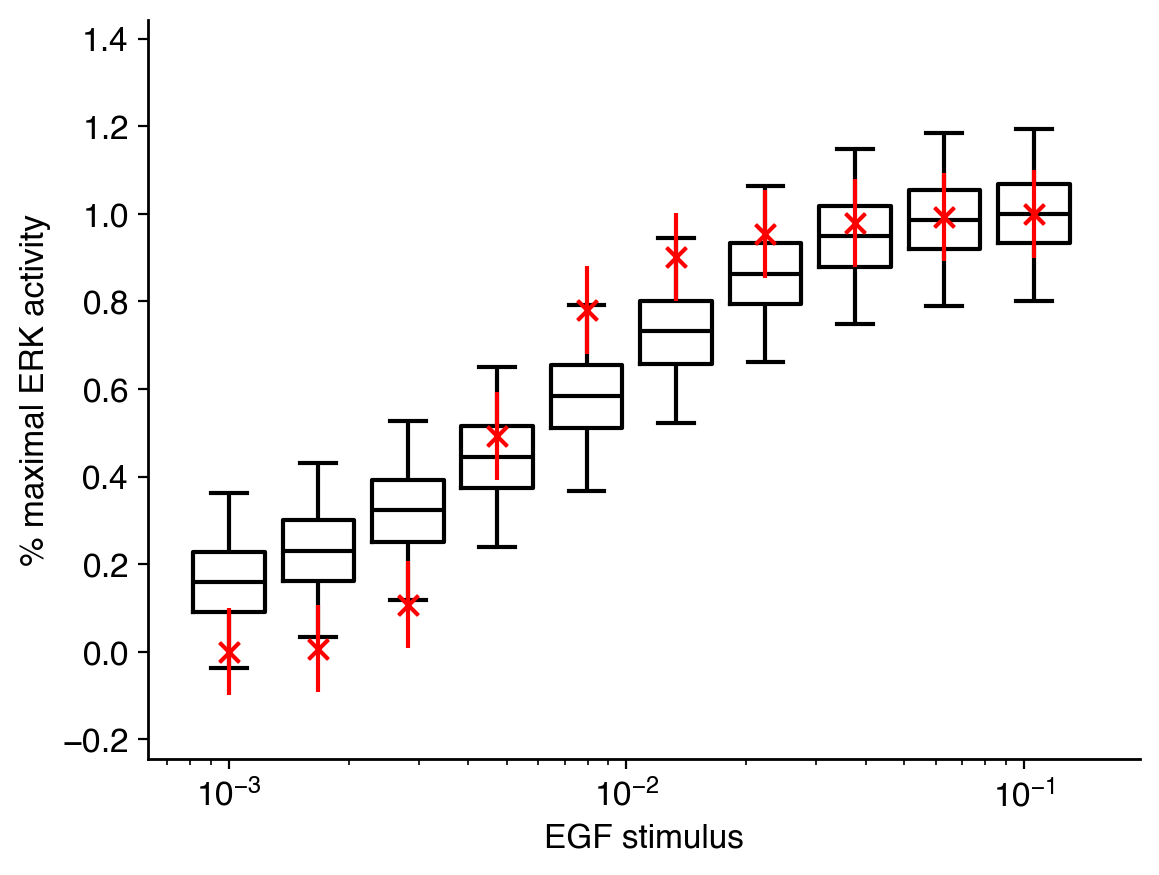

In [29]:
create_posterior_predictive(model, idata, 'shin_2014', erk_act_data, inputs, './', seed=np.random.default_rng(seed=123))

In [28]:
rvs = [rv.name for rv in model.value_vars]
logdensity_fn = get_jaxified_logp(model)

# Get the initial position from PyMC
init_position_dict = model.initial_point()
init_position = [init_position_dict[rv] for rv in rvs]

rng_key, warmup_key = jax.random.split(rng_key)

adapt = blackjax.window_adaptation(blackjax.nuts, logdensity_fn)
(last_state, parameters), _ = adapt.run(warmup_key, init_position, 1000)
kernel = blackjax.nuts(logdensity_fn, **parameters).step


In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

In [ ]:
rng_key, sample_key = jax.random.split(rng_key)
states, infos = inference_loop(sample_key, kernel, last_state, 5000)

NameError: name 'inference_loop' is not defined

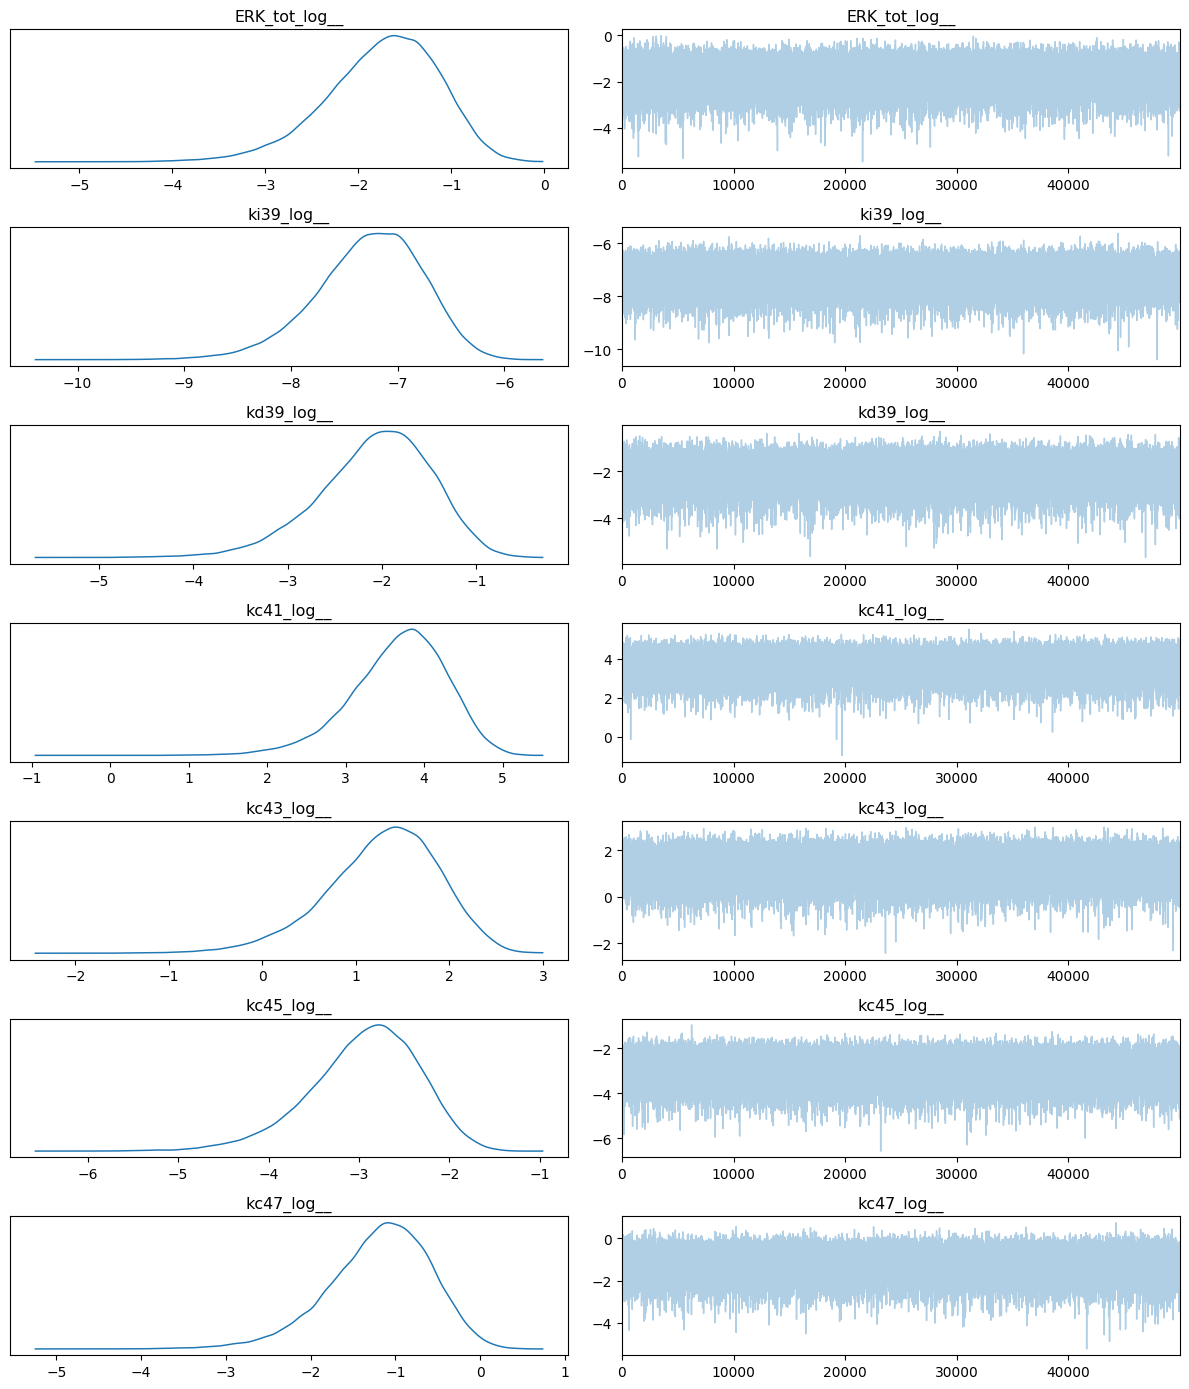

In [ ]:
import matplotlib.pyplot as plt
import arviz as az

idata = az.from_dict(
    posterior={k: v[None, ...]
               for k, v in zip(model.initial_point().keys(), states.position)})
az.plot_trace(idata)
plt.tight_layout();

In [ ]:
stim_reponse_curves = jnp.squeeze(jax.vmap(sol_op_jax_jitted)(states.position))

In [326]:
params = jnp.array(states.position)

In [348]:
logdensity_fn(params[:,-1])

Array(-134.81680404, dtype=float64)

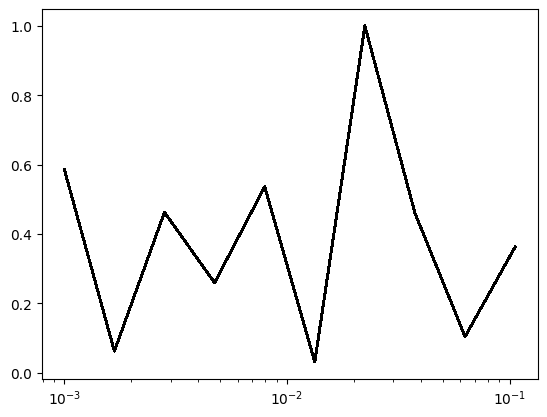

In [ ]:
fig, ax = plt.subplots()
for i in range(4500, 5000):
    ax.plot(inputs, stim_reponse_curves[i], 'k', alpha=0.1)
    ax.set_xscale('log')

In [182]:
# # get info
# S_2014 = shin_2014(transient=True)
# y0_dict, y0 = S_2014.get_initial_conditions()
# p_dict, plist = S_2014.get_nominal_params()

# data = pd.read_csv("../../../results/MAPK/HF_96_synthetic_data.csv")
# inputs = np.array(data['stimulus'].to_numpy())
# erk_act_data = data['response'].to_numpy()

# y0_EGF_ins = construct_y0_EGF_inputs(inputs, np.array([y0]), 0)

# # free params
# free_param_names = ['kc47', 'kc43', 'kd39', 'kc45', 'ERK_tot', 'ki39', 'kc41']
# free_param_idxs = [list(p_dict.keys()).index(name) for name in free_param_names]

# # set priors
# prior_param_dict = set_prior_params(list(p_dict.keys()), plist, free_param_idxs, prior_family={'Gamma':['alpha', 'beta']}, upper_mult=1.9, lower_mult=0.1, prob_mass_bounds=0.95)

# # build a pymc model
# model = build_pymc_model__(list(p_dict.keys()), prior_param_dict, erk_act, y0_EGF_ins, 
#                     [-1], 540, diffrax.ODETerm(S_2014))

In [133]:
rvs = [rv.name for rv in model.value_vars]
logdensity_fn = get_jaxified_logp(model)
print(logdensity_fn(np.array(plist)[free_param_idxs]))

-9.705667760844224e+22


In [ ]:
init_position_dict = model.initial_point()
init_position = [init_position_dict[rv] for rv in rvs]

rng_key, warmup_key = jax.random.split(rng_key)

adapt = blackjax.window_adaptation(blackjax.nuts, logdensity_fn)
(last_state, parameters), _ = adapt.run(warmup_key, init_position, 1000)
kernel = blackjax.nuts(logdensity_fn, **parameters).step

RuntimeError: Cannot reverse-mode autodifferentiate when using `diffeqsolve(..., max_steps=None, adjoint=RecursiveCheckpointAdjoint(checkpoints=None))`. This is because JAX needs to know how much memory to allocate for saving the forward pass. You should either put a bound on the maximum number of steps, or explicitly specify how many checkpoints to use.